## dataload

In [1]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename
os.environ["LOGNAME"]='cwj'
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'lgbm_user_acc_difficulty.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845539, 48), (1845539, 1), (1974, 48), (1974, 1))

## Hyper Parameter 설정

In [2]:
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

In [3]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty',
       'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std',
       'user_tag_acc_mean', 'user_pbnum_acc_mean', 'user_tag_difficulty',
       'user_pbnum_difficulty'],
      dtype='object')

## user_tag_acc_mean 추가

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM user_tag_acc_mean 추가] 피처: 31개',
 '사용된 피처(31)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_difficulty, pb_num_difficulty, user_tag_acc_mean')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20138
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.329181
[200]	valid_0's binary_logloss: 0.280163
[300]	valid_0's binary_logloss: 0.264976
[400]	valid_0's binary_logloss: 0.257331
[500]	valid_0's binary_logloss: 0.252519
[600]	valid_0's binary_logloss: 0.249612
[700]	valid_0's binary_logloss: 0.24751
[800]	valid_0's binary_logloss: 0.245477
[900]	valid_0's binary_logloss: 0.242723
[1000

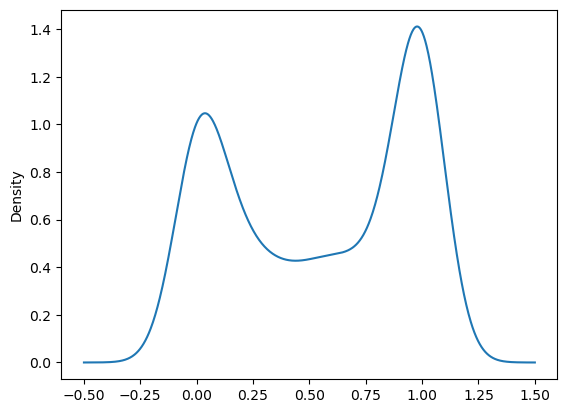

In [4]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_difficulty',
         'pb_num_difficulty',
         'user_tag_acc_mean'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM user_tag_acc_mean 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model3 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model3.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model3_run_id=run.info.run_id
    post_slack("done")
    print(f"{model3_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model3, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [10]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.6769
run_id = '9f01fdbf766f4765b5749fa57aadfdc5'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: 9f01fdbf766f4765b5749fa57aadfdc5


## user_tag_difficulty 추가

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM user_tag_difficulty 추가] 피처: 32개',
 '사용된 피처(32)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_difficulty, pb_num_difficulty, user_tag_acc_mean, user_tag_difficulty')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20296
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.329288
[200]	valid_0's binary_logloss: 0.280026
[300]	valid_0's binary_logloss: 0.264887
[400]	valid_0's binary_logloss: 0.257157
[500]	valid_0's binary_logloss: 0.252811
[600]	valid_0's binary_logloss: 0.249545
[700]	valid_0's binary_logloss: 0.247206
[800]	valid_0's binary_logloss: 0.244916
[900]	valid_0's binary_logloss: 0.24299
[1000

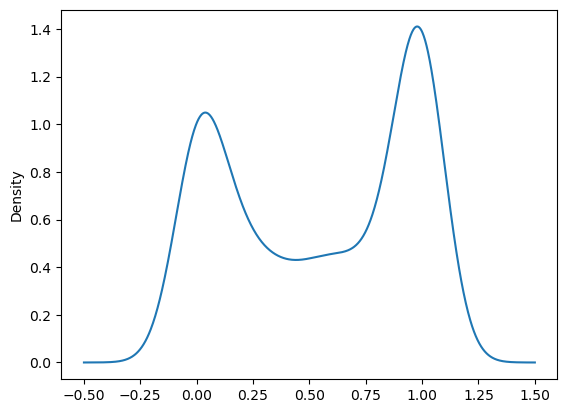

In [5]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_difficulty',
         'pb_num_difficulty',
         'user_tag_acc_mean',
         'user_tag_difficulty',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM user_tag_difficulty 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model4 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model4.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model4_run_id=run.info.run_id
    post_slack("done")
    print(f"{model4_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model4, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## user_pbnum_acc_mean만 추가

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM user_pbnum_acc_mean만 추가] 피처: 31개',
 '사용된 피처(31)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_difficulty, pb_num_difficulty, user_pbnum_acc_mean')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20233
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.50728
[200]	valid_0's binary_logloss: 0.472802
[300]	valid_0's binary_logloss: 0.463581
[400]	valid_0's binary_logloss: 0.458891
[500]	valid_0's binary_logloss: 0.455879
[600]	valid_0's binary_logloss: 0.453959
[700]	valid_0's binary_logloss: 0.452631
[800]	valid_0's binary_logloss: 0.451633
[900]	valid_0's binary_logloss: 0.451043
[1000

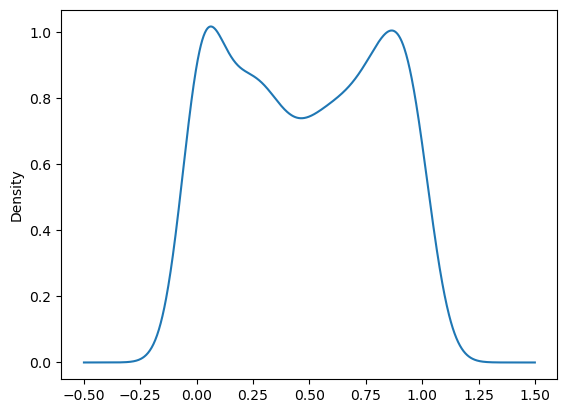

In [8]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_difficulty',
         'pb_num_difficulty',
         'user_pbnum_acc_mean'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM user_pbnum_acc_mean만 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model5 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model5.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model5_run_id=run.info.run_id
    post_slack("done")
    print(f"{model5_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model5, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [9]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.7781
run_id = 'fdfc86e854b54e10982cf666cb9b48da'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: fdfc86e854b54e10982cf666cb9b48da


## user_pbnum_difficulty만 추가

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM user_pbnum_difficulty만 추가] 피처: 31개',
 '사용된 피처(31)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_difficulty, pb_num_difficulty, user_pbnum_difficulty')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20233
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improv

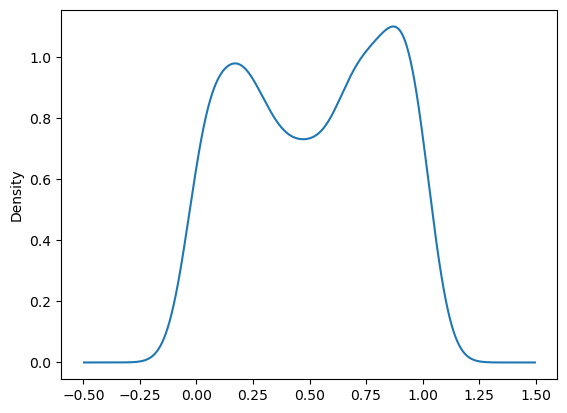

In [13]:
# Hyper parameter 설정
params = {
    "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_difficulty',
         'pb_num_difficulty',
         'user_pbnum_difficulty'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM user_pbnum_difficulty만 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model6 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=500,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model6.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model6_run_id=run.info.run_id
    post_slack("done")
    print(f"{model6_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model6, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

### HP 튜닝

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM user_pbnum_difficulty만 추가 HP 튜닝] 피처: 31개',
 '사용된 피처(31)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_difficulty, pb_num_difficulty, user_pbnum_difficulty')

[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17075
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 31
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Inf

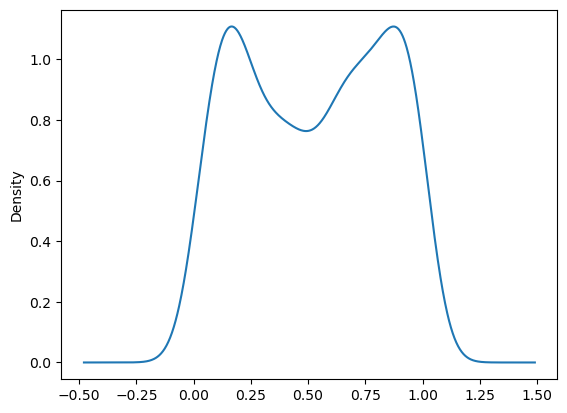

In [17]:
# Hyper parameter 설정
params = {
    "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 0.75,
    "max_cat_group": 64,
    "objective": "binary",
    "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
     'lambda_l1': 9.5, 
     'lambda_l2': 0.005, 
    'min_child_samples': 20,
}
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_difficulty',
         'pb_num_difficulty',
         'user_pbnum_difficulty'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM user_pbnum_difficulty만 추가 HP 튜닝] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model61 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=500,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model61.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model61_run_id=run.info.run_id
    post_slack("done")
    print(f"{model61_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model61, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()